# Toy Model: Filtering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_factor_simple, suppression_simulation
from sbin import parameters

## Read in the data

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [2]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('tables/kendall+kepler.pkl', 'rb') as file:
       tmp = pickle.load(file)
db = tmp[ tmp['koi_disposition']!='FALSE POSITIVE' ]

print('Binaries, all planets', len(db))
print('Binaries, unique stars', len(db['KOI'].unique()))

Binaries, all planets 396
Binaries, unique stars 286


In [3]:
# read in my kois table
with open('tables/kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']!='FALSE POSITIVE') & \
                 np.isfinite(kois['parallax']) & \
                 (kois['ruwe']<1.2) ]

print('KOIs, all', len(kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']!='FALSE POSITIVE')]) )
print('KOIs, singles', len(kois_less))
print('KOIs, unique stars', len(kois_less['KOI'].unique()))

KOIs, all 4329
KOIs, singles 3982
KOIs, unique stars 3019


(array([  39.,   43.,   79.,  112.,  213.,  466.,  882., 1275., 1364.,
        1304.,  862.,  485.,  299.,  192.,   90.,   59.,   57.,   47.,
          41.,   31.,   38.,   36.,   12.,   29.,   32.,   30.,   36.,
          24.,   18.,   23.]),
 array([0.8      , 0.8233333, 0.8466667, 0.87     , 0.8933333, 0.9166667,
        0.94     , 0.9633333, 0.9866667, 1.01     , 1.0333333, 1.0566666,
        1.08     , 1.1033334, 1.1266667, 1.15     , 1.1733333, 1.1966667,
        1.22     , 1.2433333, 1.2666667, 1.29     , 1.3133334, 1.3366667,
        1.36     , 1.3833333, 1.4066666, 1.43     , 1.4533334, 1.4766667,
        1.5      ], dtype=float32),
 <BarContainer object of 30 artists>)

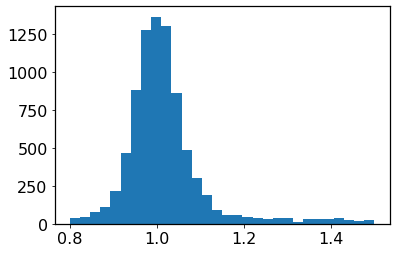

In [4]:
plt.hist(kois['ruwe'], range=[0.8,1.5], bins=30)

### CKS Sample

In [5]:
tmp = Table.read('tables/fulton2018.vot').to_pandas()
tmp['kepoi_name'] = tmp['KOI']
tmp['KOI'] = tmp['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)
cks=tmp.merge(kois, on='kepoi_name', suffixes=['','_y'])

In [6]:
cks_less = cks[ (~cks['kepoi_name'].isin(db['kepoi_name'])) & \
                (cks['koi_disposition']!='FALSE POSITIVE') & \
                 np.isfinite(cks['parallax']) & \
                 (cks['ruwe']<1.2) &  (cks['koi_kepmag']<14.2) ]

print('CKS, all planets', len(cks_less))
print('CKS, unique stars', len(cks_less['KOI'].unique()))

CKS, all planets 1026
CKS, unique stars 704


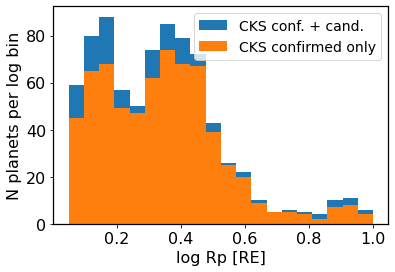

In [7]:
plt.hist(np.log10(cks_less['Rp']), range=(0.05,1), bins=20,
        label='CKS conf. + cand.')
plt.hist(np.log10(cks_less['Rp'][cks_less['koi_disposition']=='CONFIRMED']), 
         range=(0.05,1), bins=20,
         label='CKS confirmed only')
plt.xlabel('log Rp [RE]')
plt.ylabel('N planets per log bin')
plt.legend()

## Define subsamples

In [8]:
lum = (db['Teff1'].astype(float)/5777.)**4 * db['Rstar1']**2
db['Mass1'] = lum**0.25
lum = (db['Teff2'].astype(float)/5777.)**4 * (db['Rstar2_Rstar1']*db['Rstar1'])**2
db['Mass2'] = lum**0.25

q = db['Mass1']/db['Mass2']
RL = 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3))) # verified against https://dev.adsabs.harvard.edu/scan/
disk = RL * db['SepAU']

db['DiskAU'] = disk

db['SnowAU'] = 0.00465*0.5*(db['Teff1']/170.)**2 # for T_eq = 170K

In [9]:
# period and stellar limits
plim = (db['koi_period'] < 100) 
kplim = (kois_less['koi_period'] < 100)  & \
        (1000./kois_less['parallax'] < 2200)
cksplim = (cks_less['Per'] < 100) & \
        (1000./cks_less['parallax'] < 2200)
       

# filter the binaries
db_filtered = db[(db['Rppri'] < parameters.radius_limit) & plim].copy()
close = db_filtered['SepAU']<100
good = db_filtered['e_Rpkep']/db_filtered['Rpkep'] < parameters.max_radius_error

# filter the KOIs
kois_filtered = kois_less[(kois_less['koi_prad']<parameters.radius_limit) & kplim].copy()
kois_good = (kois_filtered['koi_prad_err1'] - kois_filtered['koi_prad_err2'])/kois_filtered['koi_prad']/2. < parameters.max_radius_error

# Filter CKS
cks_filtered = cks_less[(cks_less['Rp']<parameters.radius_limit) & cksplim].copy()
cks_good = (cks_filtered['koi_prad_err1'] - cks_filtered['koi_prad_err2'])/cks_filtered['Rp']/2. < parameters.max_radius_error



In [10]:
np.percentile( (db_filtered['e_Rppri']/db_filtered['Rppri'])[good], q=[50,86.4])

array([0.15894039, 0.29495501])

In [11]:
np.percentile( (db_filtered['e_Rpkep']/db_filtered['Rpkep'])[good], q=[50,86.4])

array([0.13793103, 0.26603964])

In [12]:
len(db['KOI'][np.isnan(db['parallax'])].unique())

31

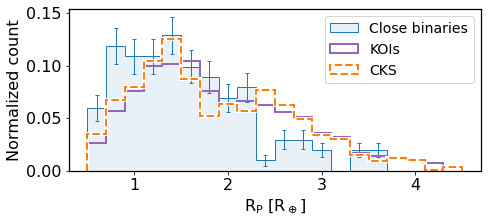

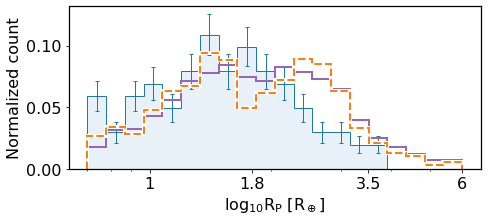

In [13]:

for option in ['linear','log']:

    nbins=20

    if option=='linear':
        histrange=[0.5,4.5]
        bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
    else:
        histrange=[np.log10(0.7),np.log10(6)]
        bin_edges = np.logspace(histrange[0], histrange[1], nbins + 1)
        
    bin_width = np.diff(bin_edges)
    bin_center = bin_edges[:-1]+bin_width/2.
        
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    nplanets = len(db_filtered[good & close])
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    # planets with good radii in binary systems with rho<100 au and planet period < 100 days
    y, _, _ = plt.hist(db_filtered['Rppri'][good & close], 
                  bins=bin_edges, weights=ww,
             histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
            label='Close binaries')

    plt.errorbar(bin_center, y, np.sqrt(y)/len(y), ls='None', lw=1, capsize=2, c='C0')

    # compared to the kois that are at least not definite binaries with good radii and per<100 days
    nplanets = len(kois_filtered[kois_good])
    plt.hist(kois_filtered['koi_prad'][kois_good], 
                  bins=bin_edges,  weights = 1./np.full(nplanets, nplanets, dtype=float),
                 histtype='step', lw=2, color='C4',
            label='KOIs')

    # compared to the cks
    nplanets = len(cks_filtered[cks_good])
    plt.hist(cks_filtered['Rp'][cks_good], 
                 bins=bin_edges,  weights = 1./np.full(nplanets, nplanets, dtype=float),
                 histtype='step',lw=4, color='white')
    plt.hist(cks_filtered['Rp'][cks_good], 
                 bins=bin_edges,  weights = 1./np.full(nplanets, nplanets, dtype=float),
                 histtype='step',lw=2, linestyle='--', color='C1',
            label='CKS')

    plt.ylabel('Normalized count')
    
    if option=='linear':
        plt.legend()
        plt.xlabel('$R_P$ [$R_\oplus$]')        
    else:
        plt.xlabel('$log_{10} R_P$ [$R_\oplus$]')  
        plt.xscale('log')
        
        custom_log_ticks = [1, 1.8, 3.5, 6]
        plt.gca().set_xticks(custom_log_ticks)
        plt.gca().set_xticklabels([str(t) for t in custom_log_ticks])
        
    plt.tight_layout()
    #plt.savefig('prad-'+option+'.png')

    plt.xlim()
    
    
    

In [14]:
bundle = {
    "db_filtered": db_filtered,      # pandas DataFrame
    "close": close,                  # boolean Series
    "good": good,                    # boolean Series
    "kois_filtered": kois_filtered,  # pandas DataFrame
    "kois_good": kois_good,          # boolean Series
    "cks_filtered": cks_filtered,    # pandas DataFrame
    "cks_good": cks_good,            # boolean Series
}

with open("filtered_data.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


## Get numbers for paper

In [15]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='Rppri')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='Rppri')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='Rppri')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='Rppri', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='Rppri', MTPS=True)


print("\n\nSINGLE KOIS")
print("\n (err < lim)")
calc_statistics(kois_filtered[kois_good], prad_col='koi_prad')
print("\n (any err)")
calc_statistics(kois_filtered, prad_col='koi_prad', MTPS=True)
print("\nSINGLE CKS")
print("\n (err < lim)")
calc_statistics(cks_filtered[cks_good])
print("\n (any err)")
calc_statistics(cks_filtered, MTPS=True)

BINARIES

 All
Number of planets:  337
Number of stars:  252
Frac super-Earths/n_planets:  0.5548961424332344 +- 0.04057802472159449

 Close (error good)
Number of planets:  101
Number of stars:  69
Frac super-Earths/n_planets:  0.6831683168316832 +- 0.08224380062295124

 Wide (error good)
Number of planets:  236
Number of stars:  183
Frac super-Earths/n_planets:  0.5 +- 0.046028730894916166

 Close (any error)
Number of planets:  104
Number of stars:  71
Frac super-Earths/n_planets:  0.6634615384615384 +- 0.07987138329728918
Frac MTPS:  22 49 0.30985915492957744 +- 0.06606219380033

 Wide (any error)
Number of planets:  242
Number of stars:  188
Frac super-Earths/n_planets:  0.5 +- 0.045454545454545456
Frac MTPS:  35 153 0.18617021276595744 +- 0.03146850948457243


SINGLE KOIS

 (err < lim)
Number of planets:  2965
Number of stars:  2166
Frac super-Earths/n_planets:  0.503204047217538 +- 0.01302745896514534

 (any err)
Number of planets:  3031
Number of stars:  2223
Frac super-Earths/

### Investigate trends

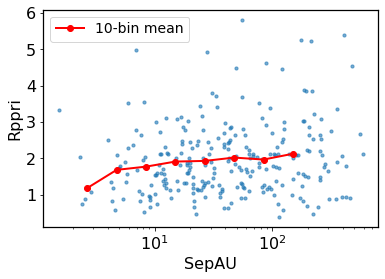

In [18]:
# biggest planet
max_rp = db_filtered.loc[db_filtered.groupby('KOI')['Rppri'].idxmax()].reset_index(drop=True)

# scatter 
y = max_rp['DiskAU']/max_rp['SnowAU']
plt.scatter(y, max_rp['Rppri'], s=10, alpha=0.6)
plt.xscale('log')
plt.xlabel('SepAU'); plt.ylabel('Rppri')

# 10 log-spaced bins (11 edges)
#bins = np.logspace(np.log10(20), np.log10(3000), 11)
bins = np.logspace(np.log10(2), np.log10(200), 9)

# assign points to bins
bin_idx = np.digitize(y.values, bins)

# keep only points inside [bins[0], bins[-1]]
valid = (bin_idx >= 1) & (bin_idx <= len(bins) - 1)
tmp = max_rp.loc[valid, ['Rppri']].copy()
tmp['bin'] = bin_idx[valid]

# mean Rppri per bin, ensure length 10 (fill missing bins with NaN)
means = tmp.groupby('bin')['Rppri'].mean().reindex(range(1, len(bins))).values

# plot at bin centers (geometric mean of edges)
centers = np.sqrt(bins[:-1] * bins[1:])
plt.plot(centers, means, color='red', linewidth=2, marker='o', label='10-bin mean')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(kois_filtered['koi_period'], kois_filtered['koi_prad'], marker='.',
         edgecolor='gray', alpha=0.5, lw=1, facecolor='None', label='Kepler')

plt.scatter(db_filtered['koi_period'][~close], db_filtered['Rppri'][~close] ,
         edgecolor='C2', facecolor='None', lw=1, label='Wide binaries')
plt.scatter(db_filtered['koi_period'][close], db_filtered['Rppri'][close] ,
         edgecolor='C0', lw=1, facecolor='None', label='Close binaries')


plt.xlim(0.5,100)
plt.ylim(0.1,6)
plt.axhline(0.5)
plt.xscale('log')
plt.xlabel('Period [d]')
plt.ylabel('Rp [Re]')
plt.legend()

In [ ]:
plt.figure(figsize=(10,7))
err = db_filtered['e_Rpkep']/db_filtered['koi_prad']
plt.scatter(db_filtered['Rppri'][err>0.15], db_filtered['koi_prad'][err>0.15], lw=2, edgecolor='k', facecolor='None')
plt.scatter(db_filtered['Rppri'], db_filtered['koi_prad'], c=err, 
            cmap='Blues_r', vmin=0, vmax=0.25)
plt.xlabel('Rp (Sullivan+) [Re]')
plt.ylabel('Rp (Kepler) [Re]')
plt.colorbar(label='Rp error')
plt.show()